In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Commodities Stat

In [103]:
all_commodities = pd.read_csv('Data/all_commodities.csv')

In [104]:
all_commodities.head()

,Date-Time,Value,Unit,Commodity
0,2024-01-01,203.879130,Cents per Pound,Coffee
1,2023-12-01,210.310476,Cents per Pound,Coffee
2,2023-11-01,197.433182,Cents per Pound,Coffee
3,2023-10-01,183.951364,Cents per Pound,Coffee
4,2023-09-01,183.589048,Cents per Pound,Coffee


In [105]:
all_commodities.Commodity.unique()

array(['Coffee', 'Corn', nan, 'Sugar'], dtype=object)

In [106]:
all_commodities.Unit.unique()

array(['Cents per Pound', 'Dollar per Metric Ton', nan], dtype=object)

#### Handling NA values

In [107]:
all_commodities.isna().sum()

Date-Time      0
Value          0
Unit         408
Commodity    408
dtype: int64

In [108]:
all_commodities[all_commodities['Commodity']=='Corn'].count()

Date-Time    1
Value        1
Unit         1
Commodity    1
dtype: int64

In [109]:
all_commodities[all_commodities['Commodity']=='Coffee'].count()

Date-Time    409
Value        409
Unit         409
Commodity    409
dtype: int64

In [110]:
all_commodities['Commodity'].fillna('Corn', inplace=True)

/var/folders/r3/qqpsr8sx0lbdr0s9mqjzr1nh0000gn/T/ipykernel_59842/2046639336.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_commodities['Commodity'].fillna('Corn', inplace=True)


#### Groupby Commodity

In [111]:
grouped_commodity = all_commodities.groupby(['Commodity','Date-Time']).sum()

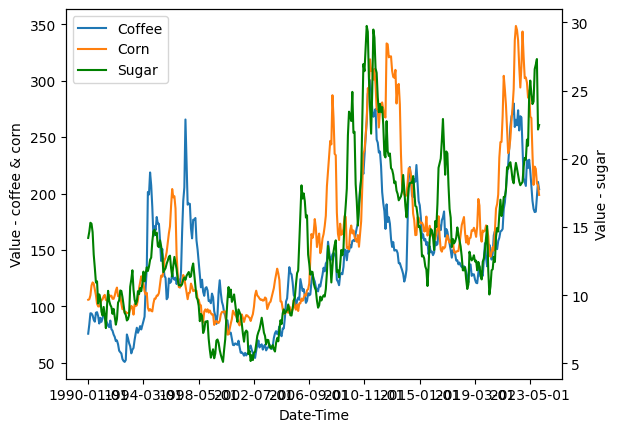

In [112]:
fig,ax1= plt.subplots()

grouped_commodity.loc[('Coffee',),'Value'].plot(ax=ax1,label='Coffee')
grouped_commodity.loc[('Corn',),'Value'].plot(ax=ax1,label='Corn')
ax1.set_ylabel('Value - coffee & corn')

ax2 = ax1.twinx()
grouped_commodity.loc[('Sugar',),'Value'].plot(ax=ax2, label='Sugar',color='green')
ax2.set_ylabel('Value - sugar')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc='upper left')

## Meat Stat

In [113]:
Meat_Cold_Storage = pd.read_csv('Data/Meat_Stats_Cold_Storage.csv')
Meat_Production = pd.read_csv('Data/Meat_Stats_Meat_Production.csv')
Meat_Slaughter_Counts = pd.read_csv('Data/Meat_Stats_Slaughter_Counts.csv')
Meat_Slaughter_Weights = pd.read_csv('Data/Meat_Stats_Slaughter_Weights.csv')

In [114]:
Meat_Cold_Storage.Animal.unique()

array(['Beef', 'Veal', 'Pork', 'Lamb and Mutton', 'Broiler',
       'Other Chicken', 'Turkey', 'Frozen Eggs'], dtype=object)

In [115]:
Meat_Production.Animal.unique()

array(['Beef', 'Veal', 'Pork', 'Lamb and Mutton', 'Broilers',
       'Other Chicken', 'Turkey'], dtype=object)

In [116]:
Meat_Production
Meat_Production['Date'] = pd.to_datetime(Meat_Production['Date'], format='%b-%Y')
Meat_Production['Production'] = Meat_Production['Production'].str.replace(',', '').astype(float)

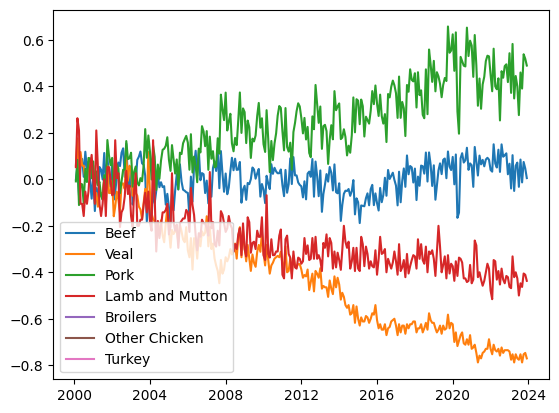

In [127]:
animal_list = list(Meat_Production.Animal.unique())
animal = 'Beef'

for animal in animal_list:
    # tmp = Meat_Production[(Meat_Production['Animal'] == animal)] == 'Commercial')].sort_index(ascending=False)
    tmp = Meat_Production[(Meat_Production['Animal'] == animal) & (Meat_Production['Commercial or Federally Inspected'] == 'Commercial')].sort_index(ascending=False)
    
    tmp = tmp[tmp['Year'] >= 2000]
        
    tmp = tmp.dropna()
    
    tmp['production_cumgrowth'] = tmp['Production'].pct_change().add(1).cumprod() - 1
    tmp['production_growth'] = tmp['Production'].pct_change()
    # tmp['rolling_mean_3m'] = tmp['Production'].rolling(window=3).mean()
        
    tmp = tmp.reset_index(drop=True)

    plt.plot(tmp['Date'], tmp['production_cumgrowth'], label=animal)
    plt.legend()

In [145]:
import pandas as pd
import statsmodels.api as sm

df = Meat_Production[(Meat_Production['Animal'] == 'Beef') & (Meat_Production['Commercial or Federally Inspected'] == 'Commercial')].sort_index(ascending=False)
df = pd.read_csv('Intermediate_data/Total_meat_production.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df = df.dropna()
df = df[df.index > '2000-01-01']
df

,Production
Date,
2000-02-01,10375.8
2000-03-01,11142.8
2000-04-01,9688.1
2000-05-01,10867.2
2000-06-01,10998.5
...,...
2023-08-01,13939.4
2023-09-01,12994.7
2023-10-01,14154.8


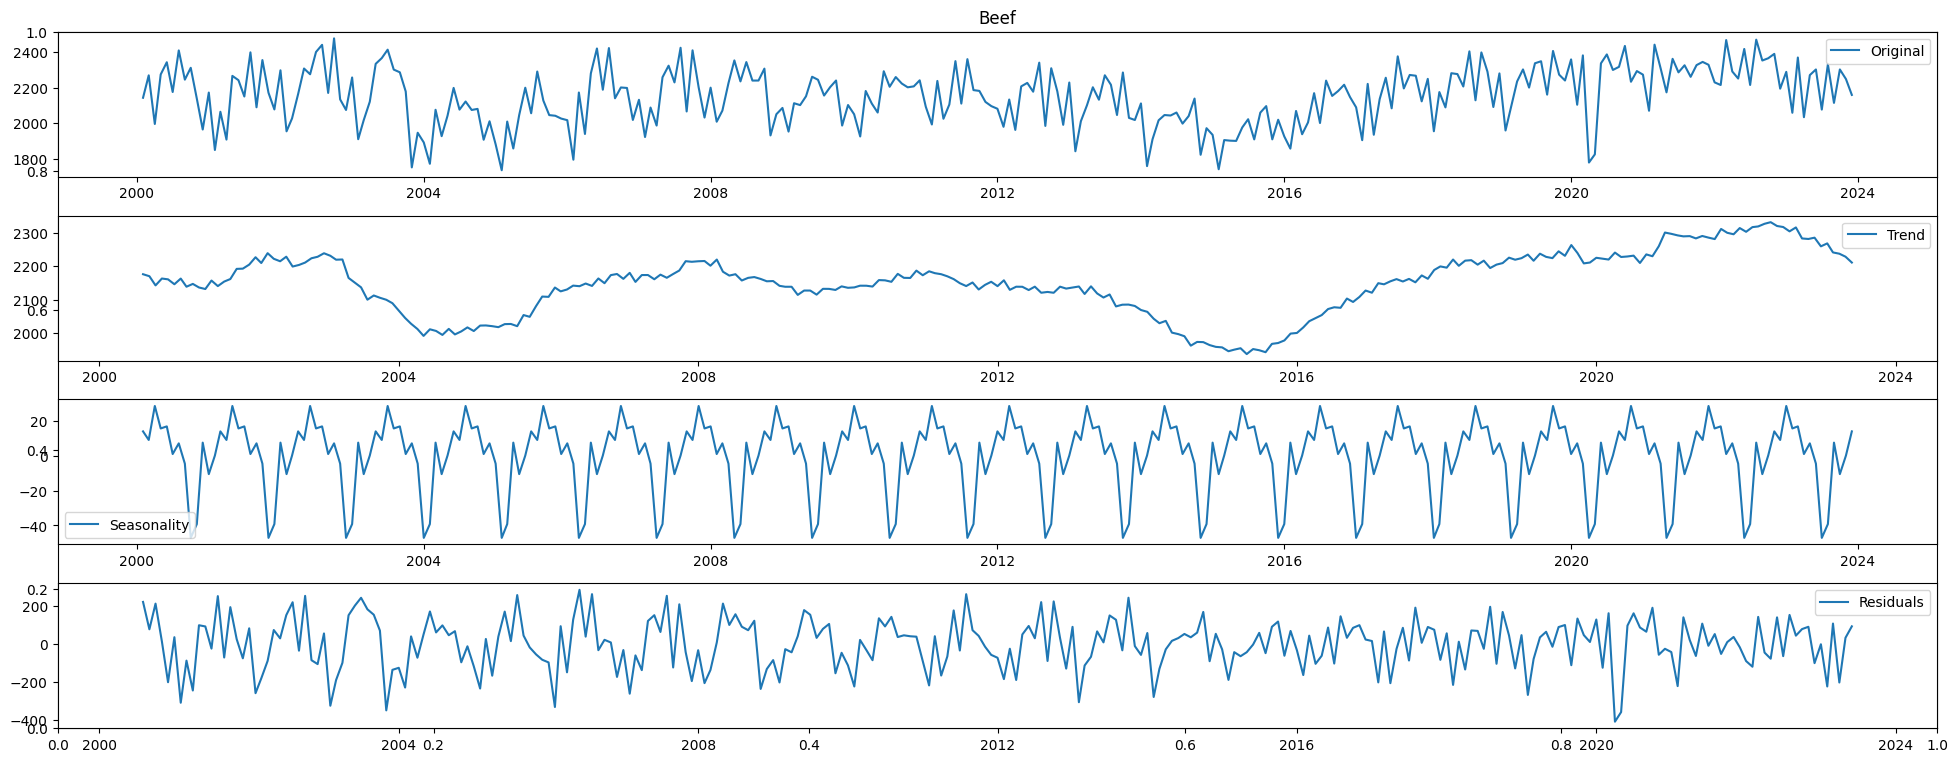

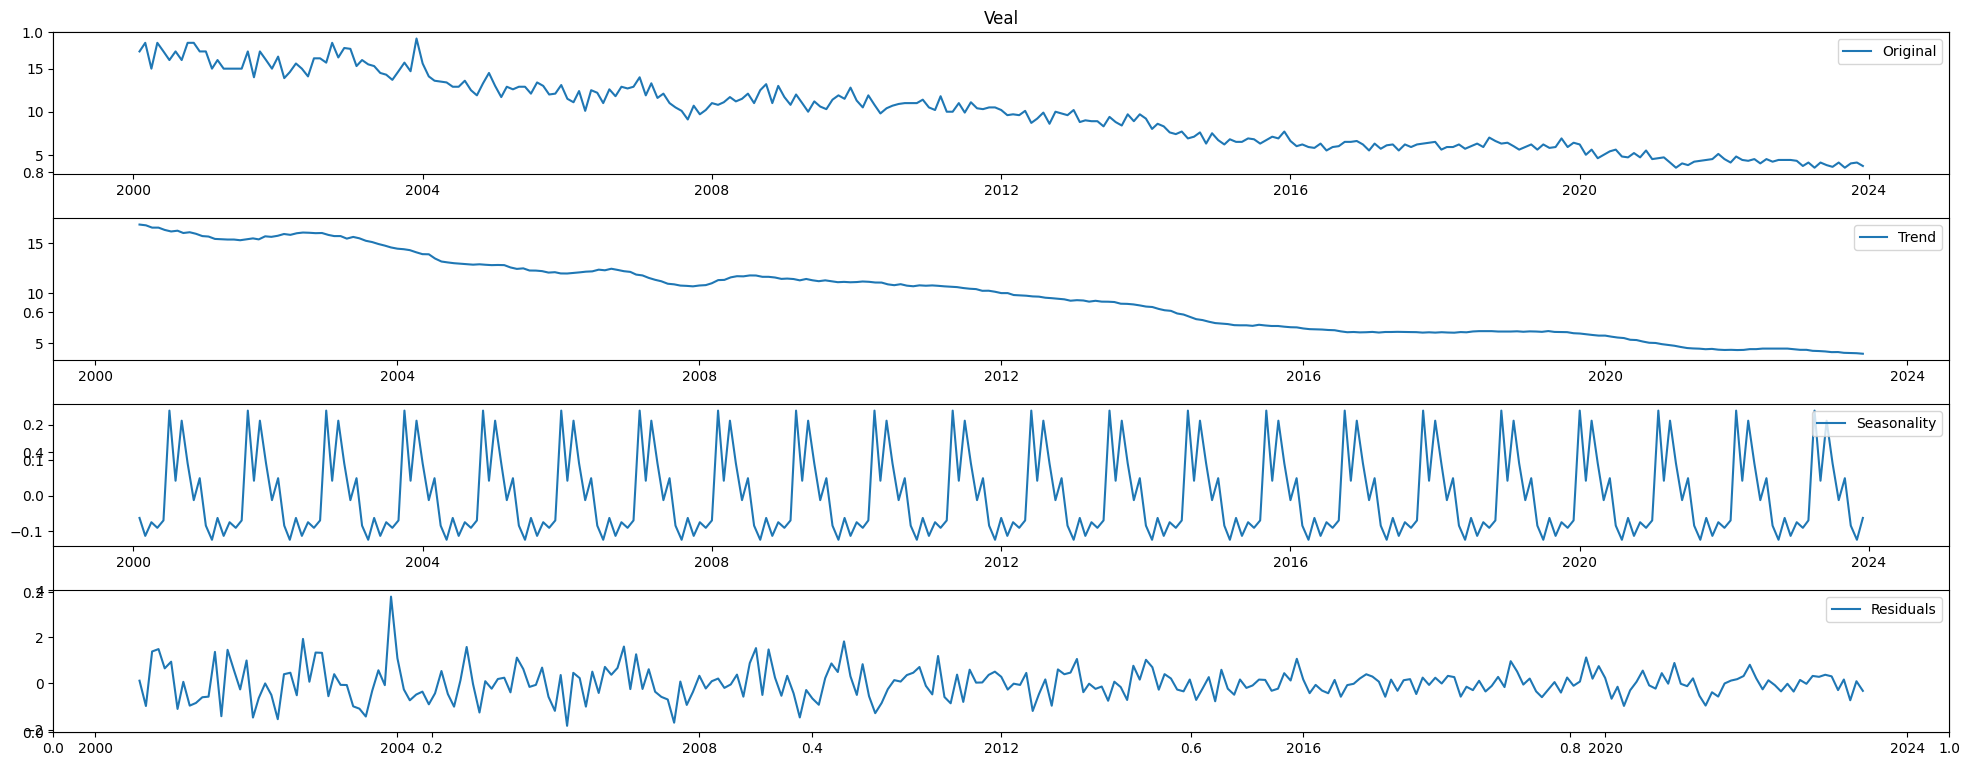

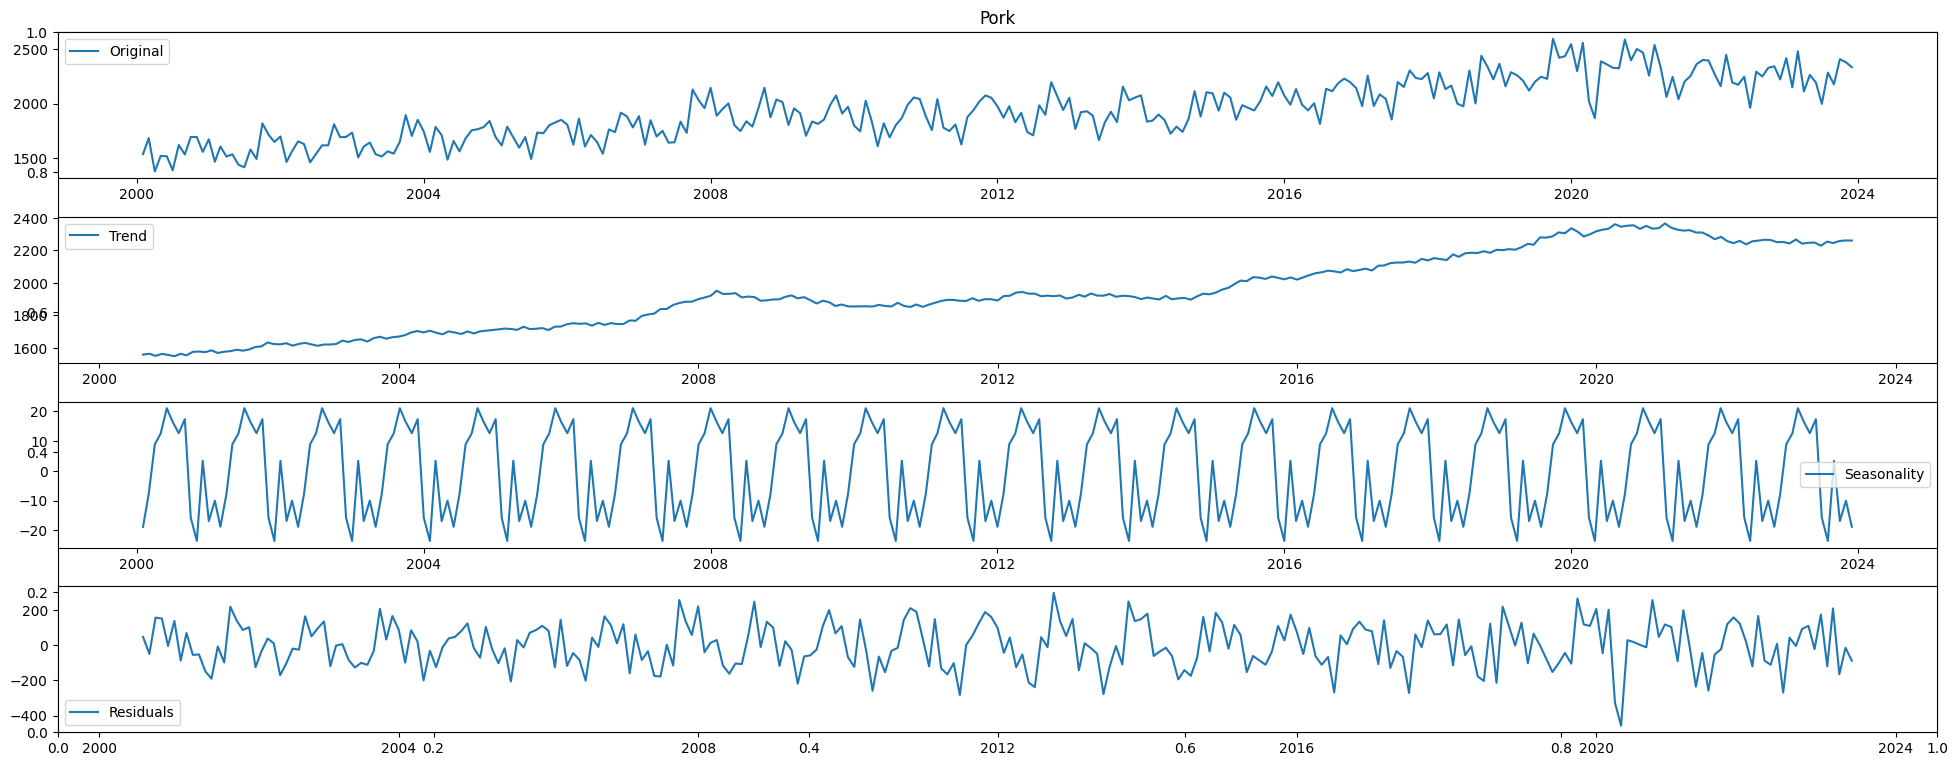

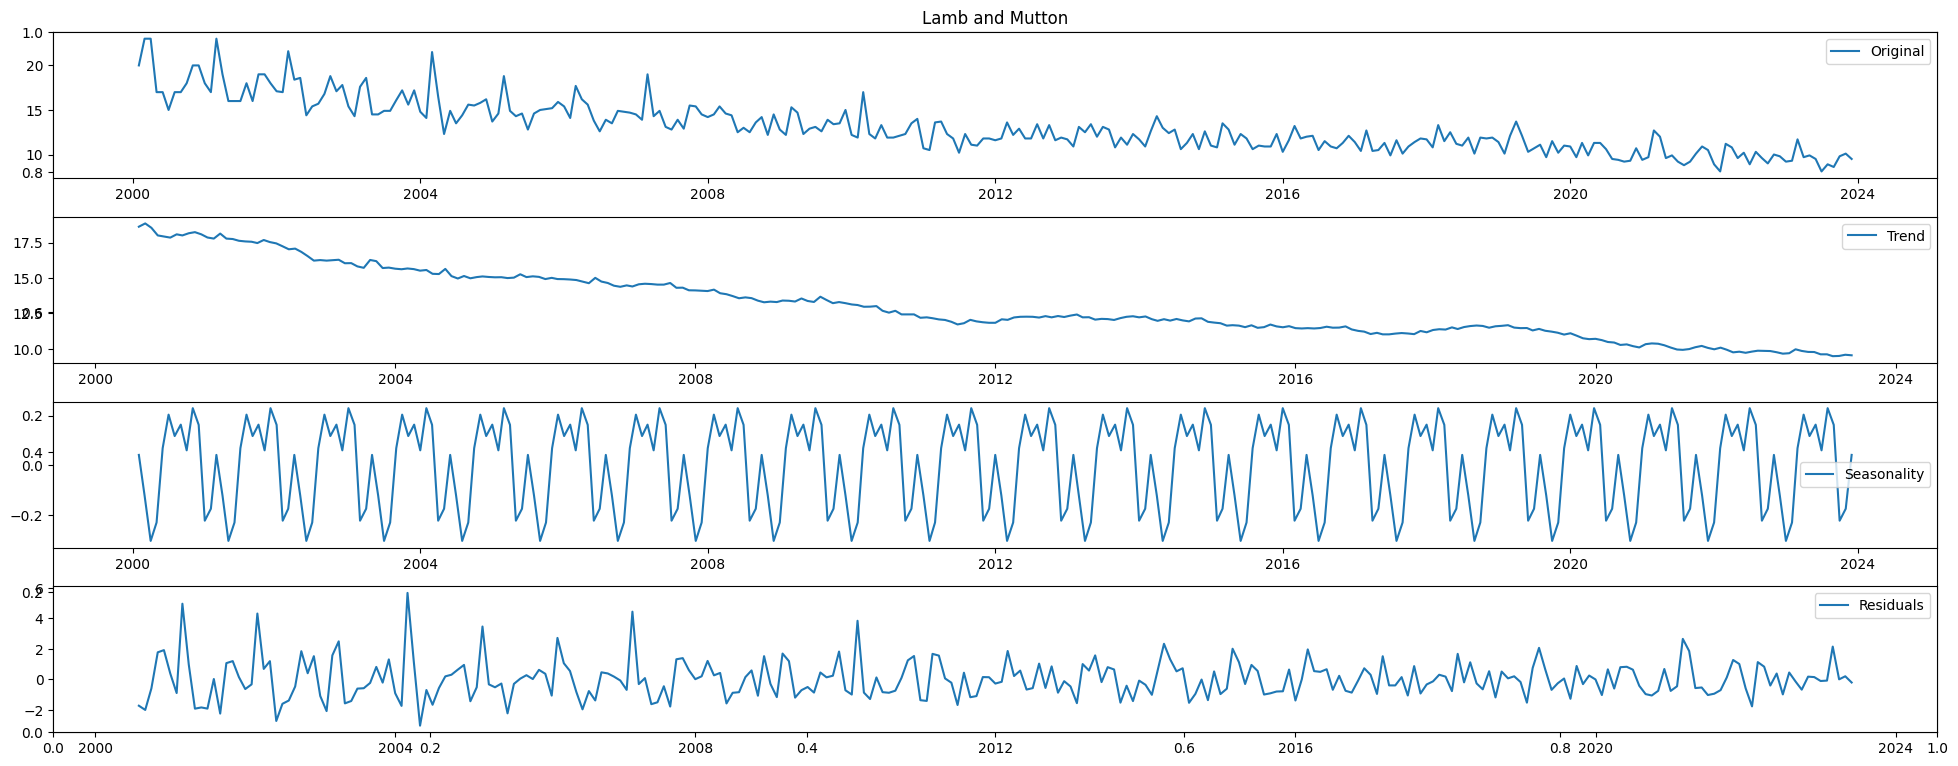

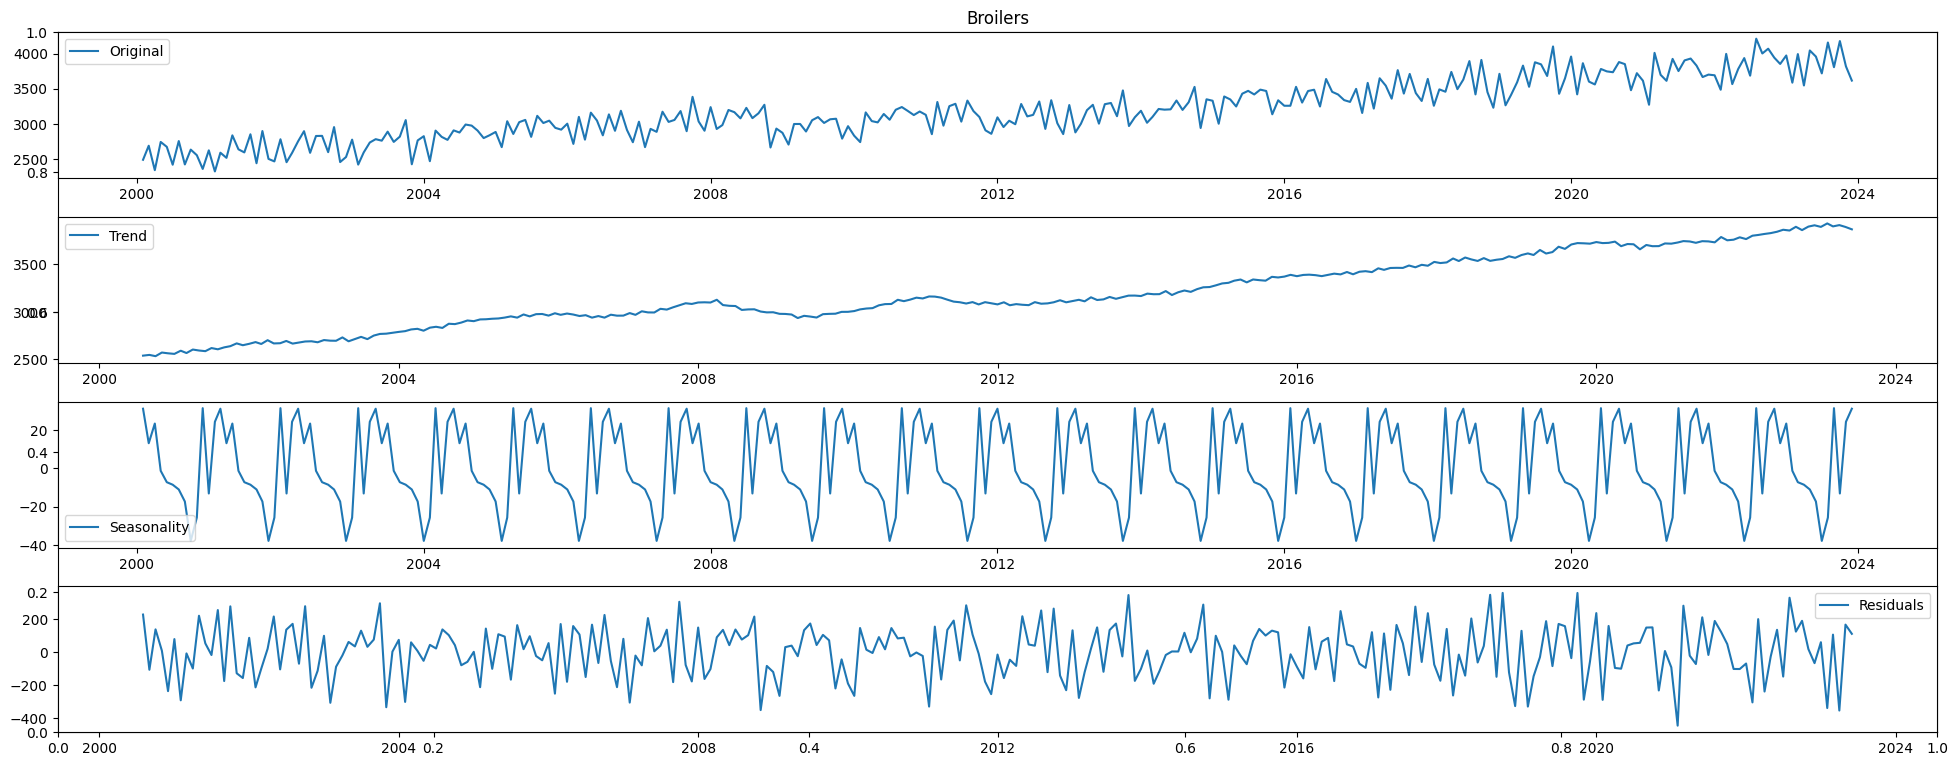

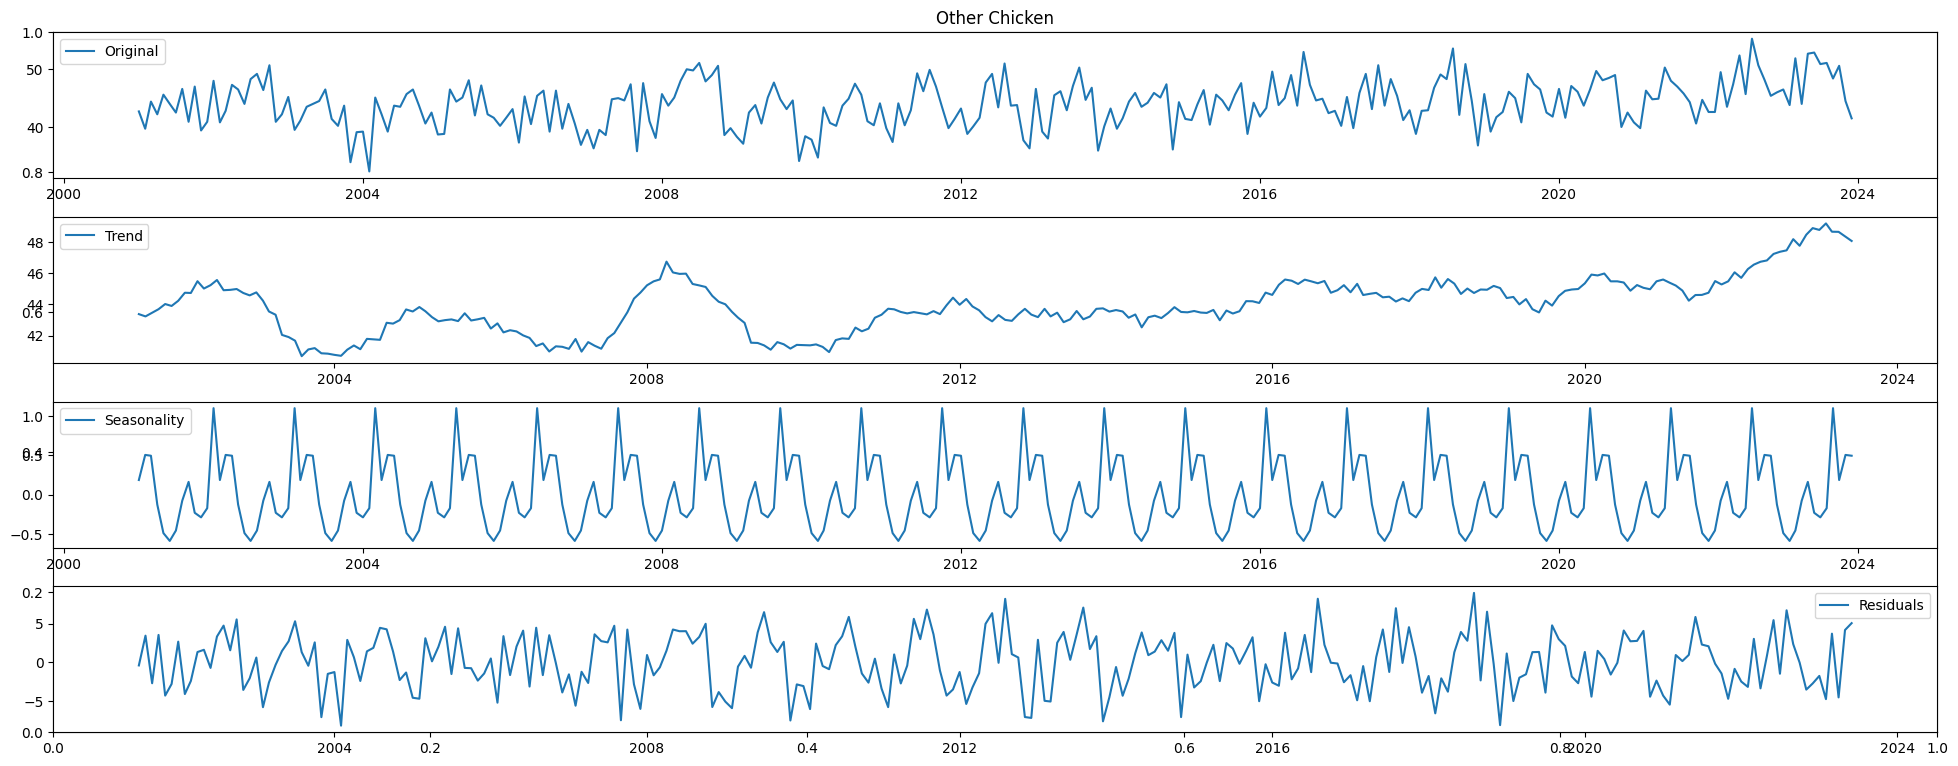

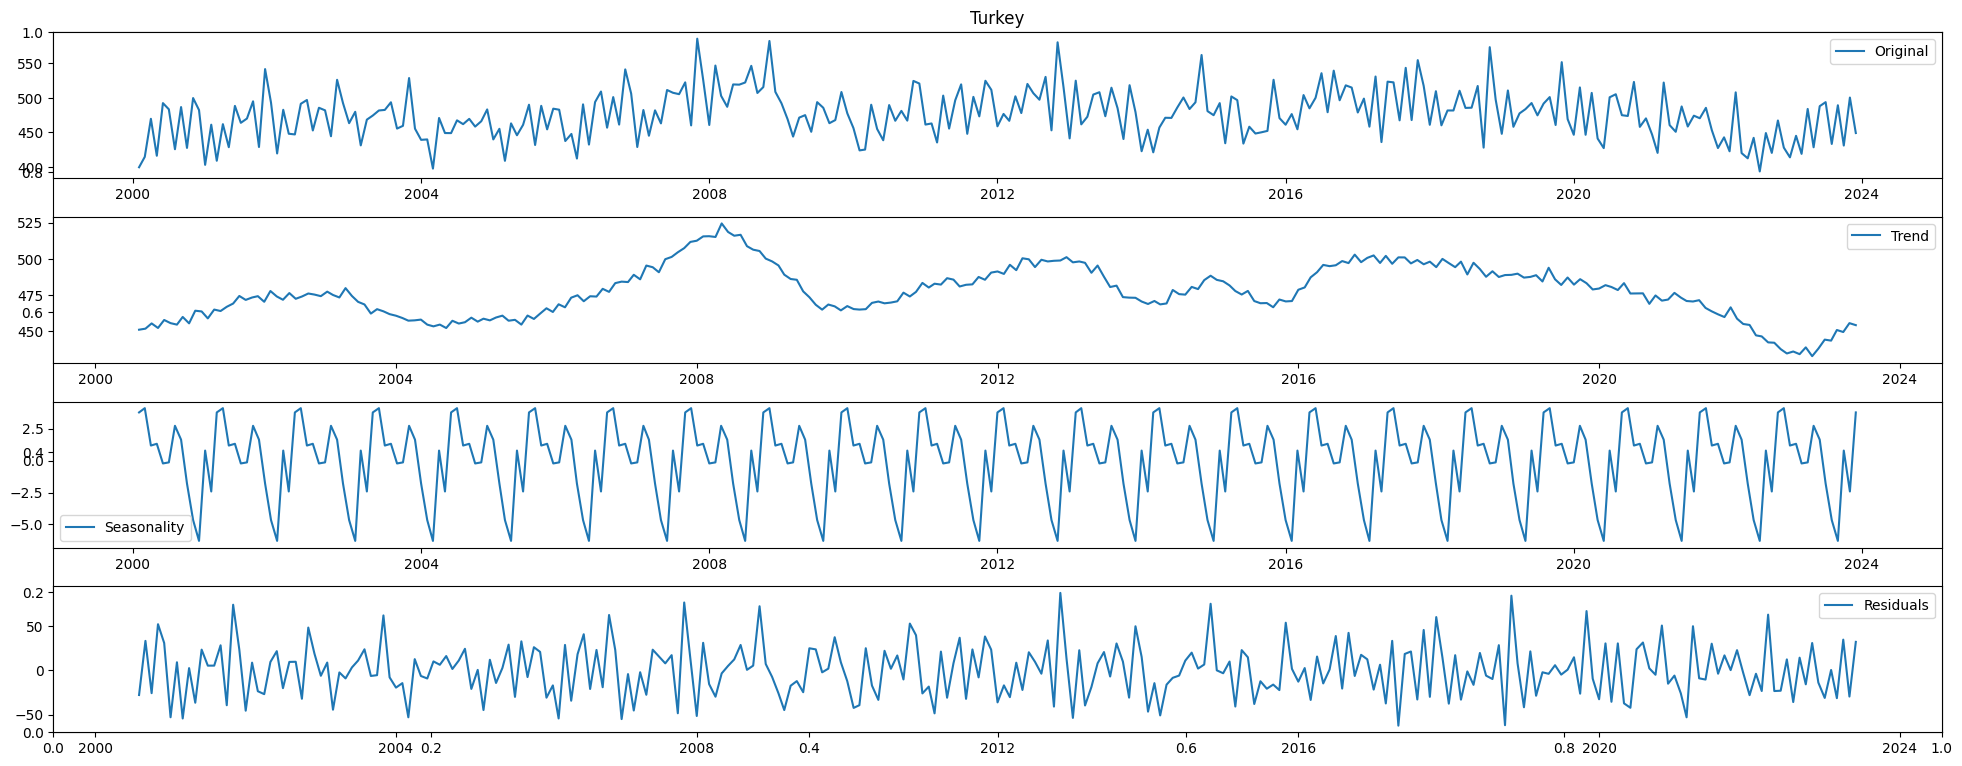

In [149]:
import matplotlib.pyplot as plt

for animal in animal_list:
    df = Meat_Production[(Meat_Production['Animal'] == animal) & (Meat_Production['Commercial or Federally Inspected'] == 'Federally Inspected')].sort_index(ascending=False)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    df = df.dropna()
    df = df[df.index > '2000-01-01']
    
    decomposition = sm.tsa.seasonal_decompose(df['Production'], period=13)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.figure(figsize=(20, 8))
    plt.title(animal)
    plt.subplot(4, 1, 1)
    plt.plot(df['Production'], label='Original')
    plt.legend(loc='best')
    plt.subplot(4, 1, 2)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(4, 1, 3)
    plt.plot(seasonal, label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(4, 1, 4)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

## Stock Stat

In [ ]:
all_stock_and_etfs = pd.read_csv('Data/all_stock_and_etfs.csv')
stock_descriptions = pd.read_csv('Data/stock_descriptions.csv')

In [ ]:
all_stock_and_etfs.head()

,Date-Time,Open,High,Low,Close,Volume,Ticker_Symbol
0,2024-02-20,29.09,29.7100,29.0001,29.44,2673889,HRL
1,2024-02-16,29.01,29.1700,28.7650,28.99,5655091,HRL
2,2024-02-15,28.94,29.2210,28.8500,29.11,2380372,HRL
3,2024-02-14,28.76,28.8254,28.5100,28.80,2690379,HRL
4,2024-02-13,29.56,29.8000,28.6350,28.72,4173650,HRL


In [ ]:
all_stock_and_etfs

,Date-Time,Open,High,Low,Close,Volume,Ticker_Symbol
0,2024-02-20,29.09,29.7100,29.0001,29.44,2673889,HRL
1,2024-02-16,29.01,29.1700,28.7650,28.99,5655091,HRL
2,2024-02-15,28.94,29.2210,28.8500,29.11,2380372,HRL
3,2024-02-14,28.76,28.8254,28.5100,28.80,2690379,HRL
4,2024-02-13,29.56,29.8000,28.6350,28.72,4173650,HRL
...,...,...,...,...,...,...,...
163552,1999-11-05,9.25,9.5000,9.2500,9.50,2300,ALG
163553,1999-11-04,9.31,9.4400,9.3100,9.31,1100,ALG
163554,1999-11-03,9.00,9.2500,9.0000,9.19,35000,ALG
163555,1999-11-02,8.75,8.8800,8.6200,8.88,7700,ALG


In [ ]:
stock_descriptions.head()

,Symbol,AssetType,Name,Description,Sector,Industry
0,QSR,Common Stock,Restaurant Brands International Inc,"Restaurant Brands International Inc. owns, ope...",TRADE & SERVICES,RETAIL-EATING PLACES
1,ALG,Common Stock,Alamo Group Inc,"Alamo Group Inc. designs, manufactures, distri...",TECHNOLOGY,FARM MACHINERY & EQUIPMENT
2,SBUX,Common Stock,Starbucks Corporation,Starbucks Corporation is an American multinati...,TRADE & SERVICES,RETAIL-EATING & DRINKING PLACES
3,CAG,Common Stock,ConAgra Foods Inc,"Conagra Brands, Inc. (formerly ConAgra Foods) ...",MANUFACTURING,FOOD AND KINDRED PRODUCTS
4,HRL,Common Stock,Hormel Foods Corporation,Hormel Foods Corporation is an American compan...,MANUFACTURING,MEAT PACKING PLANTS


In [ ]:
stock_descriptions

,Symbol,AssetType,Name,Description,Sector,Industry
0,QSR,Common Stock,Restaurant Brands International Inc,"Restaurant Brands International Inc. owns, ope...",TRADE & SERVICES,RETAIL-EATING PLACES
1,ALG,Common Stock,Alamo Group Inc,"Alamo Group Inc. designs, manufactures, distri...",TECHNOLOGY,FARM MACHINERY & EQUIPMENT
2,SBUX,Common Stock,Starbucks Corporation,Starbucks Corporation is an American multinati...,TRADE & SERVICES,RETAIL-EATING & DRINKING PLACES
3,CAG,Common Stock,ConAgra Foods Inc,"Conagra Brands, Inc. (formerly ConAgra Foods) ...",MANUFACTURING,FOOD AND KINDRED PRODUCTS
4,HRL,Common Stock,Hormel Foods Corporation,Hormel Foods Corporation is an American compan...,MANUFACTURING,MEAT PACKING PLANTS
5,DPZ,Common Stock,Domino’s Pizza Inc,"Domino's Pizza, Inc., branded as Domino's, is ...",TRADE & SERVICES,WHOLESALE-GROCERIES & RELATED PRODUCTS
6,CMG,Common Stock,Chipotle Mexican Grill Inc,"Chipotle Mexican Grill, Inc., often known simp...",TRADE & SERVICES,RETAIL-EATING PLACES
7,DRI,Common Stock,Darden Restaurants Inc,"Darden Restaurants, Inc. is an American multi-...",TRADE & SERVICES,RETAIL-EATING PLACES
8,GIS,Common Stock,General Mills Inc,"General Mills, Inc., is an American multinatio...",MANUFACTURING,GRAIN MILL PRODUCTS
9,TSCO,Common Stock,Tractor Supply Company,Tractor Supply Company (TSCO) is an American r...,TRADE & SERVICES,"RETAIL-BUILDING MATERIALS, HARDWARE, GARDEN SU..."


In [ ]:
stock_descriptions['Sector'].unique()

array(['TRADE & SERVICES', 'TECHNOLOGY', 'MANUFACTURING', 'MULTIPLE'],
      dtype=object)

In [ ]:
all_stock_and_etfs.Ticker_Symbol.nunique()

29